## Importing dependencies

In [1]:
%matplotlib inline
import numpy as np 
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Model

# Read And Combining train dataset (kaggle dataset)

In [2]:
# number of class
n_class = 5

# path to kaggle dataset
root_path = "./Dataset/"

# list of folders
folder_list = os.listdir(root_path)
image_path_list = []
label_list = []

# for each folder, get the image path and labels
for folder in folder_list:
    for label in range(n_class):
        
        # get all the images path inside the current folder
        image_list = os.listdir(f"{root_path}{folder}/{label}")
        # add to the image path list
        image_path_list += [ f"{root_path}{folder}/{label}/"+ path for path in image_list]
        
        # add labels to the label list
        label_list += [label] * len(image_list)

# convert to dataframe
df_train_kaggle = pd.DataFrame({"filepath" : image_path_list, "label": label_list})

In [3]:
df_train_kaggle.shape

(9786, 2)

### Observation
we have total of 9786 images in kaggle dataset. We will use data to train the deep learning model
# Lets look at class distribution

Text(0, 0.5, 'count')

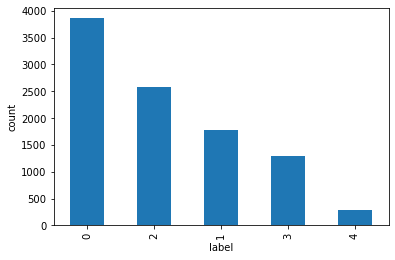

In [4]:
df_train_kaggle.label.value_counts().plot.bar()
plt.xlabel("label")
plt.ylabel("count")

### Observation
As our dataset is imbalanced, we will balance our class by weighting majority class less and minoiry class more

## DataGenerator train and validation
We will use kaggle dataset as train set and compitition dataset as validation set. If train and validation metric is similar, it shows their distribution is similar and hence we can use kaggle dataset as well.

In [47]:
# train data generator object
train_aug = ImageDataGenerator(rescale=1./255)

# validation data generator object
valid_aug = ImageDataGenerator(rescale=1./255)

In [48]:
# create train generator
train_generator = train_aug.flow_from_dataframe(
dataframe=df_train_kaggle,
directory=None,
x_col="filepath",
y_col="label",
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
target_size=(224,224))

Found 9786 validated image filenames.


# Create validation dataframe using compitition dataset.
We will download compition dataset from gdrive and use it as validation set to validated against kaggle dataset

In [31]:
# read Train.csv file which contains image names and labels and preprocess them
compi_root_path= "./KneeXray/"
df_val_compi = pd.read_csv(compi_root_path + "Train.csv")

# add absolute path to the image names
df_val_compi["filename"] = df_val_compi.filename.apply(lambda x: compi_root_path+"train/" + x)
df_val_compi.head()

,filename,label
0,./KneeXray/train/Image_1.jpg,0
1,./KneeXray/train/Image_2.jpg,1
2,./KneeXray/train/Image_3.jpg,0
3,./KneeXray/train/Image_4.jpg,1
4,./KneeXray/train/Image_5.jpg,2


Text(0, 0.5, 'count')

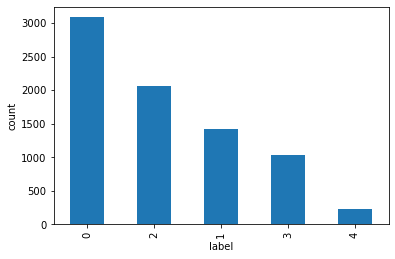

In [8]:
# class count of compitition dataset
df_val_compi.label.value_counts().plot.bar()
plt.xlabel("label")
plt.ylabel("count")

In [50]:
# create validation generator
valid_generator = valid_aug.flow_from_dataframe( 
dataframe= df_val_compi,
x_col= "filename",
y_col= "label",
batch_size= 32,
seed= 42,
shuffle= True,
class_mode= "raw",
target_size= (224,224))

Found 7828 validated image filenames.


### Model Architecture
Here we will be using Xception by google. (I encourage you to try different architectures)

In [10]:
xception = Xception(weights="imagenet",)
x=  xception.layers[-3].output

x = tf.keras.layers.Conv2D(filters= 1024, kernel_size= 3, padding= "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.Conv2D(filters= 256, kernel_size= 3, padding= "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.Conv2D(filters= 64, kernel_size= 3, padding= "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.Conv2D(filters= n_class, kernel_size= 3, padding= "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

GAP = tf.keras.layers.GlobalAveragePooling2D()(x)
pred = tf.keras.activations.softmax(GAP)

xception_model = Model(inputs=xception.input,outputs=pred)

In [11]:
# compile
xception_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001,decay=0.0001),
                 metrics=["acc"],
                 loss= tf.keras.losses.sparse_categorical_crossentropy)

# callbacks and checkpoints
checkpoint_path = "xception_best.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
my_callbacks = [
               ModelCheckpoint(checkpoint_path,
                               monitor = 'val_acc',
                               verbose = 1,
                               save_weights_only=True,
                               save_best_only = True,
                               mode="max"),
              EarlyStopping(monitor='val_loss',
                            patience=5,
                            verbose=0),
              ReduceLROnPlateau(monitor='val_loss',
                                patience=5,
                                verbose=1)
]

### Weighting classes
As we have unevenly class distibution, we will weight them based on the number of samples

In [12]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes= np.unique(df_train_kaggle.label.values),
                                                 y= df_train_kaggle.label.values)
class_weights = dict(enumerate(class_weights))

# Train
Lets roll

In [13]:
# train the model
xception_model.fit(
        train_generator,
        epochs=100,
        validation_data=valid_generator,
        callbacks=[my_callbacks],
        class_weight=class_weights)

# load best saved weights
xception_model.load_weights(checkpoint_path)

Epoch 1/100
306/306 [==============================] - ETA: 0s - loss: 1.4164 - acc: 0.3159
Epoch 1: val_acc improved from -inf to 0.26929, saving model to xception_best.ckpt
306/306 [==============================] - 192s 583ms/step - loss: 1.4164 - acc: 0.3159 - val_loss: 1.6313 - val_acc: 0.2693 - lr: 1.0000e-05
Epoch 2/100
306/306 [==============================] - ETA: 0s - loss: 1.1683 - acc: 0.4807
Epoch 2: val_acc improved from 0.26929 to 0.39371, saving model to xception_best.ckpt
306/306 [==============================] - 167s 545ms/step - loss: 1.1683 - acc: 0.4807 - val_loss: 1.5215 - val_acc: 0.3937 - lr: 1.0000e-05
Epoch 3/100
306/306 [==============================] - ETA: 0s - loss: 1.0277 - acc: 0.5697
Epoch 3: val_acc improved from 0.39371 to 0.57550, saving model to xception_best.ckpt
306/306 [==============================] - 172s 561ms/step - loss: 1.0277 - acc: 0.5697 - val_loss: 1.2175 - val_acc: 0.5755 - lr: 1.0000e-05
Epoch 4/100
306/306 [======================

### Observation
As we can see train and validation accuracy is pretty close, which proves kaggle and competition data has come from the same distribution and we can freely use it to experiment with.

## Retraining last trained model on competition data
As we have used competition data as validation set previously, we will use it as train set now (and some part of it as validation set) hoping this additional training would give our model new information to perform better.

In [14]:
# train and validation split on competition data
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(df_val_compi,
                                   test_size=0.1,
                                   random_state=42,
                                   stratify= df_val_compi.label)

In [15]:
train_generator = train_aug.flow_from_dataframe(
dataframe = X_train,
x_col="filename",
y_col="label",
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
target_size=(224,224))

Found 7045 validated image filenames.


In [16]:
valid_generator = valid_aug.flow_from_dataframe( 
dataframe=X_test,
x_col="filename",
y_col="label",
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
target_size=(224,224))

Found 783 validated image filenames.


In [17]:
# number of steps to consider 1 as  epoch
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID =valid_generator.n//valid_generator.batch_size

In [18]:
# kick off training
xception_model.fit(
        train_generator,
        steps_per_epoch=STEP_SIZE_TRAIN,
        epochs=50,
        validation_data=valid_generator,
        validation_steps=STEP_SIZE_VALID,callbacks=[my_callbacks])

Epoch 1/50
220/220 [==============================] - ETA: 0s - loss: 0.6113 - acc: 0.9323
Epoch 1: val_acc improved from 0.95171 to 0.97396, saving model to xception_best.ckpt
220/220 [==============================] - 135s 599ms/step - loss: 0.6113 - acc: 0.9323 - val_loss: 0.5067 - val_acc: 0.9740 - lr: 1.0000e-05
Epoch 2/50
220/220 [==============================] - ETA: 0s - loss: 0.5640 - acc: 0.9632
Epoch 2: val_acc did not improve from 0.97396
220/220 [==============================] - 128s 580ms/step - loss: 0.5640 - acc: 0.9632 - val_loss: 0.5230 - val_acc: 0.9701 - lr: 1.0000e-05
Epoch 3/50
220/220 [==============================] - ETA: 0s - loss: 0.5319 - acc: 0.9815
Epoch 3: val_acc did not improve from 0.97396
220/220 [==============================] - 127s 576ms/step - loss: 0.5319 - acc: 0.9815 - val_loss: 0.5268 - val_acc: 0.9727 - lr: 1.0000e-05
Epoch 4/50
220/220 [==============================] - ETA: 0s - loss: 0.5283 - acc: 0.9842
Epoch 4: val_acc improved from 0

In [19]:
# load best saved weights
xception_model.load_weights(checkpoint_path)

# Confusion Matrix
As our data set is imbalaned, lets see where is our model making mistakes. I encourage to you to take initative for bringing FPs and FNs down.

In [20]:
from sklearn.metrics import precision_recall_curve
target_shape = 224
BATCH_SIZE = 1

# test generator
compi_gen = valid_aug.flow_from_dataframe(dataframe= X_test,
                            x_col= "filename",
                            class_mode=None,
                            target_size= (target_shape, target_shape),
                            shuffle= False,
                            batch_size= BATCH_SIZE
                            )

Found 783 validated image filenames.


In [21]:
# prediction on train data
predicition_compi = xception_model.predict(compi_gen, steps= compi_gen.n/ BATCH_SIZE, verbose= 1)

783/783 [==============================] - 16s 18ms/step


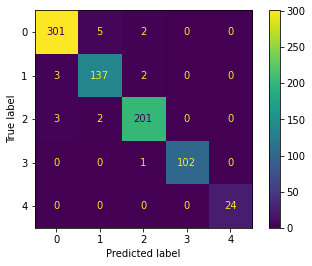

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
class_prediction_compi =  np.argmax(predicition_compi, axis= 1)
cm = confusion_matrix(X_test.label, class_prediction_compi, labels=[0, 1, 2, 3, 4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1, 2, 3, 4])
disp.plot()

## Making prediction on test set (to make submission)
Finally we save the predictions on disk in CSV format

In [23]:
# read the csv file
test = pd.read_csv(compi_root_path + "Test.csv")

# create test generator
test_generator = valid_aug.flow_from_dataframe(
dataframe= test,
directory= compi_root_path + "test",
x_col= "filename",
y_col= None,
batch_size= 1,
seed= 42,
shuffle= False,
class_mode= None,
target_size= (224,224))

# number of steps to consider 1 epoch
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

Found 1958 validated image filenames.


In [24]:
# make prediction and create dataframe out of it
pred = xception_model.predict(test_generator,steps=STEP_SIZE_TEST,verbose=1)
df_submit = pd.DataFrame({"label":np.argmax(pred, axis= 1)})
df_submit["label"].value_counts()

1958/1958 [==============================] - 35s 18ms/step


0    753
2    519
1    366
3    261
4     59
Name: label, dtype: int64

### Clearing the working directory
Because if don't, "output" tabl will show only images

In [25]:
import sys
import shutil

# Get directory name
mydir = "/kaggle/working"

try:
    shutil.rmtree(mydir)
except OSError as e:
    print("Error: %s - %s." % (e.filename, e.strerror))

Error: /kaggle/working - The system cannot find the path specified.


### Save best weights and output prediction file

In [26]:
xception_model.save_weights("knee_xray_Xceptionnet_GPA.h5")
df_submit.to_csv("submission.csv",index=False)

In [34]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load VGG19 model with imagenet weights
vgg19 = VGG19(weights="imagenet", include_top=False)

# Take output from one of the earlier layers
x = vgg19.layers[-3].output

# Add additional layers similar to the ones in your Xception model
x = Conv2D(filters=1024, kernel_size=3, padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = Conv2D(filters=256, kernel_size=3, padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = Conv2D(filters=64, kernel_size=3, padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

# Assuming n_class is defined earlier in your code
n_class = 10  # You can change this according to your problem

x = Conv2D(filters=n_class, kernel_size=3, padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

# Global Average Pooling
GAP = GlobalAveragePooling2D()(x)

# Softmax activation for classification
pred = Activation("softmax")(GAP)

# Create model
vgg19_model = Model(inputs=vgg19.input, outputs=pred)


In [35]:
# compile
vgg19_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001,decay=0.0001),
                 metrics=["acc"],
                 loss= tf.keras.losses.sparse_categorical_crossentropy)

# callbacks and checkpoints
checkpoint_path = "vgg19_best.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
my_callbacks = [
               ModelCheckpoint(checkpoint_path,
                               monitor = 'val_acc',
                               verbose = 1,
                               save_weights_only=True,
                               save_best_only = True,
                               mode="max"),
              EarlyStopping(monitor='val_loss',
                            patience=5,
                            verbose=0),
              ReduceLROnPlateau(monitor='val_loss',
                                patience=5,
                                verbose=1)]

In [36]:
# train the model
vgg19_model.fit(
        train_generator,
        epochs=100,
        validation_data=valid_generator,
        callbacks=[my_callbacks],
        class_weight=class_weights)

Epoch 1/100
306/306 [==============================] - ETA: 0s - loss: 1.9266 - acc: 0.4083
Epoch 1: val_acc improved from -inf to 0.32950, saving model to vgg19_best.ckpt
306/306 [==============================] - 146s 472ms/step - loss: 1.9266 - acc: 0.4083 - val_loss: 2.0184 - val_acc: 0.3295 - lr: 1.0000e-05
Epoch 2/100
306/306 [==============================] - ETA: 0s - loss: 1.6343 - acc: 0.5359
Epoch 2: val_acc improved from 0.32950 to 0.58621, saving model to vgg19_best.ckpt
306/306 [==============================] - 142s 463ms/step - loss: 1.6343 - acc: 0.5359 - val_loss: 1.8145 - val_acc: 0.5862 - lr: 1.0000e-05
Epoch 3/100
306/306 [==============================] - ETA: 0s - loss: 1.5481 - acc: 0.5736
Epoch 3: val_acc improved from 0.58621 to 0.60409, saving model to vgg19_best.ckpt
306/306 [==============================] - 144s 470ms/step - loss: 1.5481 - acc: 0.5736 - val_loss: 1.7523 - val_acc: 0.6041 - lr: 1.0000e-05
Epoch 4/100
306/306 [==============================]

In [37]:
target_shape = 224
BATCH_SIZE = 1

# test generator
compi_gen = valid_aug.flow_from_dataframe(dataframe= X_test,
                            x_col= "filename",
                            class_mode=None,
                            target_size= (target_shape, target_shape),
                            shuffle= False,
                            batch_size= BATCH_SIZE
                            )

Found 783 validated image filenames.


In [38]:
predicition_compi = vgg19_model.predict(compi_gen, steps= compi_gen.n/ BATCH_SIZE, verbose= 1)

783/783 [==============================] - 10s 11ms/step


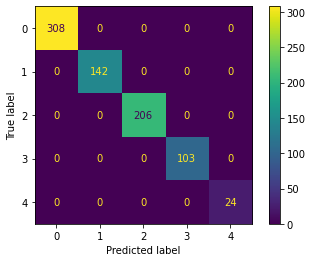

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
class_prediction_compi =  np.argmax(predicition_compi, axis= 1)
cm = confusion_matrix(X_test.label, class_prediction_compi, labels=[0, 1, 2, 3, 4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1, 2, 3, 4])
disp.plot()

In [40]:
test = pd.read_csv(compi_root_path + "Test.csv")

# create test generator
test_generator = valid_aug.flow_from_dataframe(
dataframe= test,
directory= compi_root_path + "test",
x_col= "filename",
y_col= None,
batch_size= 1,
seed= 42,
shuffle= False,
class_mode= None,
target_size= (224,224))

# number of steps to consider 1 epoch
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

Found 1958 validated image filenames.


In [41]:
# make prediction and create dataframe out of it
pred = vgg19_model.predict(test_generator,steps=STEP_SIZE_TEST,verbose=1)
df_submit = pd.DataFrame({"label":np.argmax(pred, axis= 1)})
df_submit["label"].value_counts()

1958/1958 [==============================] - 27s 14ms/step


0    753
2    519
1    366
3    261
4     59
Name: label, dtype: int64

In [42]:
vgg19_model.save_weights("knee_xray_vgg19_GPA.h5")
df_submit.to_csv("submission.csv",index=False)

In [45]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define CNN feature extractor
cnn_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
])

# Define RNN layer
rnn_model = models.Sequential([
    layers.Reshape((-1, 128)),
    layers.LSTM(64,
return_sequences=False)
])

# Combine CNN and RNN
combined_model = models.Sequential([
    cnn_model,
    rnn_model,
    layers.Dense(5, activation='softmax')
])

# Compile the model
combined_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
combined_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 86528)             93248     
                                                                 
 sequential_4 (Sequential)   (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 142,981
Trainable params: 142,981
Non-trainable params: 0
_________________________________________________________________


In [46]:
combined_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001,decay=0.0001),
                 metrics=["acc"],
                 loss= tf.keras.losses.sparse_categorical_crossentropy)

# callbacks and checkpoints
checkpoint_path = "cnnrnn_best.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
my_callbacks = [
               ModelCheckpoint(checkpoint_path,
                               monitor = 'val_acc',
                               verbose = 1,
                               save_weights_only=True,
                               save_best_only = True,
                               mode="max"),
              EarlyStopping(monitor='val_loss',
                            patience=5,
                            verbose=0),
              ReduceLROnPlateau(monitor='val_loss',
                                patience=5,
                                verbose=1)]

In [49]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes= np.unique(df_train_kaggle.label.values),
                                                 y= df_train_kaggle.label.values)
class_weights = dict(enumerate(class_weights))

In [52]:
combined_model.fit(
        train_generator,
        epochs=10,
        validation_data=valid_generator,
        callbacks=[my_callbacks],
        class_weight=class_weights)

Epoch 1/10
306/306 [==============================] - ETA: 0s - loss: 1.6102 - acc: 0.1304
Epoch 1: val_acc improved from -inf to 0.12966, saving model to cnnrnn_best.ckpt
306/306 [==============================] - 134s 436ms/step - loss: 1.6102 - acc: 0.1304 - val_loss: 1.6143 - val_acc: 0.1297 - lr: 1.0000e-05
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 1.6096 - acc: 0.1248
Epoch 2: val_acc did not improve from 0.12966
306/306 [==============================] - 52s 169ms/step - loss: 1.6096 - acc: 0.1248 - val_loss: 1.6130 - val_acc: 0.1266 - lr: 1.0000e-05
Epoch 3/10
306/306 [==============================] - ETA: 0s - loss: 1.6095 - acc: 0.1272
Epoch 3: val_acc did not improve from 0.12966
306/306 [==============================] - 50s 165ms/step - loss: 1.6095 - acc: 0.1272 - val_loss: 1.6115 - val_acc: 0.1239 - lr: 1.0000e-05
Epoch 4/10
306/306 [==============================] - ETA: 0s - loss: 1.6094 - acc: 0.1180
Epoch 4: val_acc did not improve from 0